# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset

In [25]:
dataset = get_dataset("/app/project/data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/app/project/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/app/project/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [113]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # ADD CODE HERE
    for sample in batch:
        # Get the image aand associated bounding boxes
        image = sample['image']
        boxes = sample['groundtruth_boxes']
        image_classes = sample['groundtruth_classes']
        image_size = sample['original_image_spatial_shape']
        
        # Create figure and axes
        fig, ax = plt.subplots(1)
        
        # Display the image
        ax.imshow(image)
        
        # Iterate over the bounding boxes
        for box, image_cls in zip(boxes, image_classes):
            # Extract the coordinates
            ymin, xmin, ymax, xmax = box
            ymin = int(float(ymin) * int(image_size[0]))
            ymax = int(float(ymax) * int(image_size[0]))
            xmin = int(float(xmin) * int(image_size[1]))
            xmax = int(float(xmax) * int(image_size[1]))
            # Calculate the width and height of the box
            width = xmax - xmin
            height = ymax - ymin
            
            # Create a rectangle patch
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor=COLORS[image_cls], facecolor='none')
            
            # Add the patch to the axes
            ax.add_patch(rect)
        
        # Show the plot
        plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

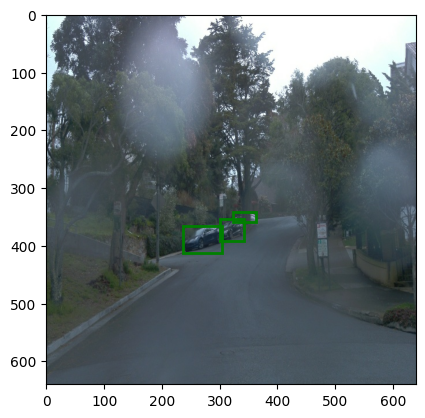

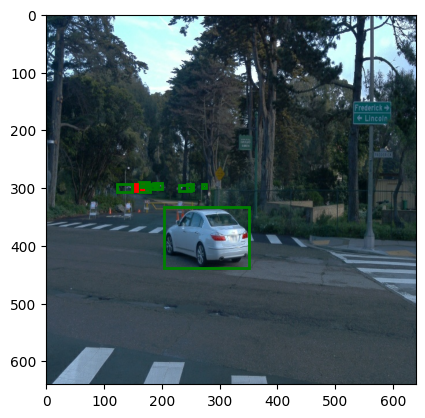

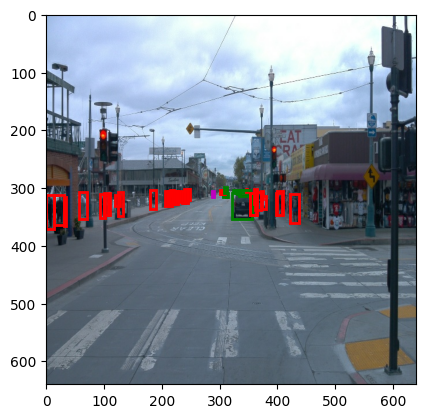

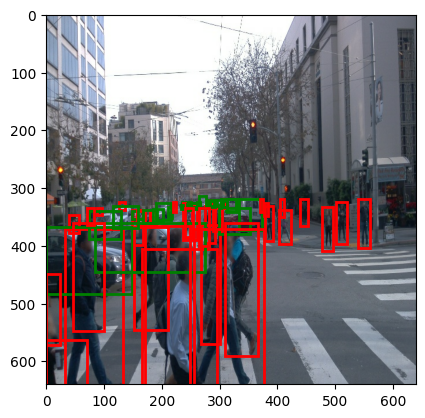

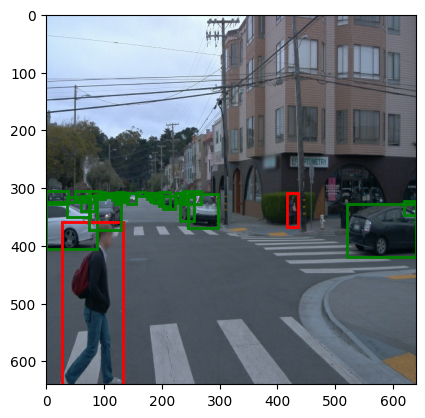

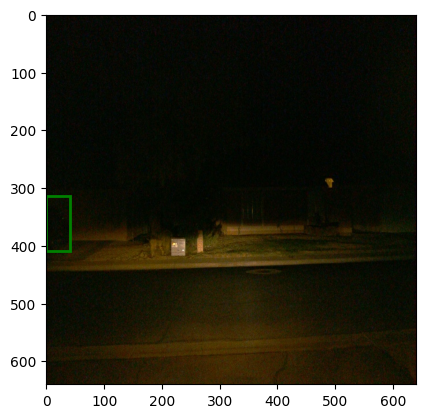

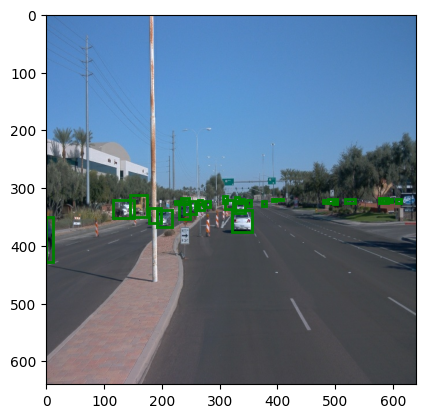

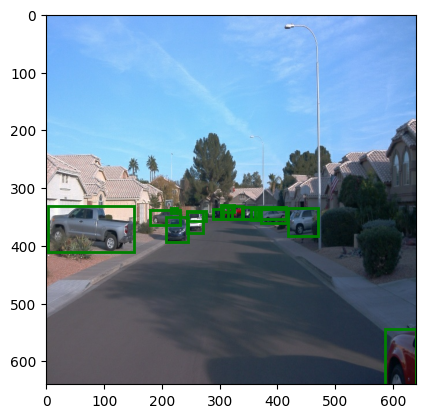

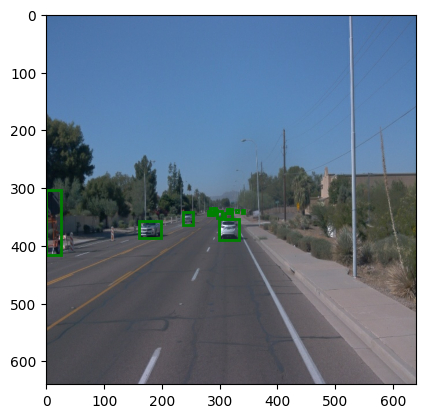

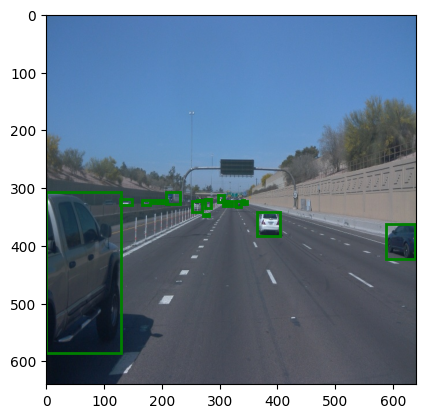

In [111]:
## STUDENT SOLUTION HERE
batch = dataset.shuffle(86).take(10)

display_instances(batch)


## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...